# Анализ завершаемости курсов e-learning продукта и RFM-сегментация пользователей

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import requests 
from urllib.parse import urlencode

In [6]:
def read_yadisk_csv(public_key,delimeter=','):
    """
    Функция для чтения csv файла с Яндекс диска. Больше информации:
    public_key - ссылка на csv-файл для скачивания
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href']
    return pd.read_csv(download_url, sep=delimeter)

In [68]:
# ссылки на данные в облаке
courses_url = 'https://disk.yandex.ru/d/S2pN3jZCiV2qnQ'
assessments_url = 'https://disk.yandex.ru/d/1ChpwkI0X72axg'
stud_assessments_url = 'https://disk.yandex.ru/d/eEkFPaydBfae4A'
stud_reg_url = 'https://disk.yandex.ru/d/zIZB58EI_atwgw'

courses          = read_yadisk_csv(courses_url)
assessments      = read_yadisk_csv(assessments_url)
stud_assessments = read_yadisk_csv(stud_assessments_url)
stud_reg         = read_yadisk_csv(stud_reg_url)

## 0. EDA. Что будем считать курсом и как оценивать их завершаемость?

По каждому предмету в каждом семестре заявлено по одному экзамену (кроме "ССС" - об этом ниже), значит курс по предмету длится один семестр - это и будем считать за курс. Также значит, что экзамен подразумевался в конце каждого семестра каждого предмета.

In [70]:
# проверим сколько было экзаменов по предметам
assessments[assessments.assessment_type == 'Exam'].groupby(['code_module','code_presentation','assessment_type']).count()

id_assessment  date  weight
code_module code_presentation assessment_type                             
AAA         2013J             Exam                         1     0       1
            2014J             Exam                         1     0       1
BBB         2013B             Exam                         1     0       1
            2013J             Exam                         1     0       1
            2014B             Exam                         1     0       1
            2014J             Exam                         1     0       1
CCC         2014B             Exam                         2     0       2
            2014J             Exam                         2     0       2
DDD         2013B             Exam                         1     1       1
            2013J             Exam                         1     1       1
            2014B             Exam                         1     1       1
            2014J             Exam                         1     0       1
EEE         2013J             Exam                         1     1       1
            2014B             Exam                         1     1       1
            2014J             Exam                         1     1       1
FFF         2013B             Exam                         1     1       1
            2013J             Exam                         1     1       1
            2014B             Exam                         1     1       1
            2014J             Exam                         1     1       1
GGG         2013J             Exam                         1     1       1
            2014B             Exam                         1     1       1
            2014J             Exam                         1     1       1

In [72]:
# посмотрим какие два дополнительных экзамена есть в предмете ССС
assessments[assessments.code_module=='CCC'].sort_values(['code_presentation','id_assessment'])

,code_module,code_presentation,id_assessment,assessment_type,date,weight
58,CCC,2014B,24282,TMA,32.0,9.0
59,CCC,2014B,24283,TMA,102.0,22.0
60,CCC,2014B,24284,TMA,151.0,22.0
61,CCC,2014B,24285,TMA,200.0,22.0
54,CCC,2014B,24286,CMA,18.0,2.0
55,CCC,2014B,24287,CMA,67.0,7.0
56,CCC,2014B,24288,CMA,137.0,8.0
57,CCC,2014B,24289,CMA,207.0,8.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0


In [135]:
# сделаем джойн оценок студентов с данными о тестах
stud_asmts_merged = stud_assessments.merge(assessments, on='id_assessment')

# удалим тесты с пропущенными оценками (оценка 0 в данных есть,
# тогда NaN заменять на 0 не стоит, вероятно, это проблема данных)
stud_asmts_merged = stud_asmts_merged.dropna(subset=['score'])

In [137]:
stud_asmts_merged.query('id_assessment in [40087, 40088]').shape[0]

0

Как видим, по предмету ССС есть данные о сдачах экзаменов, но нет по этим двум дублирующим экзаменам с выбивающимися id - вероятно, это ошибка в данных, и эти 2 лишних экзамена можно не считать

In [140]:
# посмотрим на id тестов в данных об оценках
stud_asmts_merged.groupby(['code_module','code_presentation','id_assessment','assessment_type'])\
                        .count().iloc[:30]

id_student  \
code_module code_presentation id_assessment assessment_type               
AAA         2013J             1752          TMA                     358   
                              1753          TMA                     342   
                              1754          TMA                     330   
                              1755          TMA                     303   
                              1756          TMA                     298   
            2014J             1758          TMA                     337   
                              1759          TMA                     317   
                              1760          TMA                     303   
                              1761          TMA                     280   
                              1762          TMA                     278   
BBB         2013B             14984         TMA                    1347   
                              14985         TMA                    1216   
                              14986         TMA                    1062   
                              14987         TMA                     929   
                              14988         TMA                     874   
                              14989         TMA                     763   
                              14991         CMA                    1189   
                              14992         CMA                    1070   
                              14993         CMA                     985   
                              14994         CMA                     935   
                              14995         CMA                     870   
            2013J             14996         TMA                    1695   
                              14997         TMA                    1523   
                              14998         TMA                    1311   
                              14999         TMA                    1225   
                              15000         TMA                    1162   
                              15001         TMA                    1033   
                              15003         CMA                    1490   
                              15004         CMA                    1350   
                              15005         CMA                    1257   

                                                             date_submitted  \
code_module code_presentation id_assessment assessment_type                   
AAA         2013J             1752          TMA                         358   
                              1753          TMA                         342   
                              1754          TMA                         330   
                              1755          TMA                         303   
                              1756          TMA                         298   
            2014J             1758          TMA                         337   
                              1759          TMA                         317   
                              1760          TMA                         303   
                              1761          TMA                         280   
                              1762          TMA                         278   
BBB         2013B             14984         TMA                        1347   
                              14985         TMA                        1216   
                              14986         TMA                        1062   
                              14987         TMA                         929   
                              14988         TMA                         874   
                              14989         TMA                         763   
                              14991         CMA                        1189   
                              14992         CMA                        1070   
                              14993         CMA                         985   
 

При просмотре всех оценок по тестам видно, что id тестов непрерывны только у предметов CCC и DDD, по ним есть информация о сдаче экзаменов.  
В остальных предметах как раз недостает id тестов (экзаменов) в конце каждого семестра.

Попробуем найти экзамены по их признаку - 100%-ные весы

In [143]:
stud_asmts_merged.query('weight==100').groupby(['code_module','code_presentation']).count()

id_assessment  id_student  date_submitted  \
code_module code_presentation                                              
CCC         2014B                        747         747             747   
            2014J                       1168        1168            1168   
DDD         2013B                        602         602             602   
            2013J                        968         968             968   
            2014B                        524         524             524   
            2014J                        950         950             950   

                               is_banked  score  assessment_type  date  weight  
code_module code_presentation                                                   
CCC         2014B                    747    747              747     0     747  
            2014J                   1168   1168             1168     0    1168  
DDD         2013B                    602    602              602   602     602  
            2013J                    968    968              968   968     968  
            2014B                    524    524              524   524     524  
            2014J                    950    950              950     0     950

...и так они есть только в CCC и DDD

In [146]:
assessments[assessments.weight==0].code_module.value_counts()

code_module
FFF    28
GGG    27
BBB     1
Name: count, dtype: int64

Также в курсах FFF, GGG и BBB много тестов с весом 0 - пока не ясно, как их интерпретировать.

Итак, небольшой EDA позволяет сделать такие выводы.
1. Изначально курсы по каждому предмету длятся один семестр (сначала 20xxB, затем 20xxJ) и заканчиваются экзаменом.
2. В наших данных об оценках студентов исчезли данные об экзаменах по всем предметам, кроме двух: 'CCC' и 'DDD'.
3. Так, имея пока те данные, что у нас есть, целесообразно в данной работе оценивать успешность завершения курсов:\
    а) на основании прохождения экзаменов, но только по предметам CCC и DDD;\
    б) на основании суммы взвешенных оценок по тестам за курс и факту отмены регистрации с курса у студента.

## 1. Сколько студентов успешно сдали только один курс? (если допустить, что успешная сдача — это зачёт по курсу на экзамене).

### 1 способ (по экзаменам)

Берем только тех, кто сдал экзамен успешно

In [153]:
stud_asmts_merged_exam = stud_asmts_merged[stud_asmts_merged.assessment_type=='Exam']
stud_asmts_merged_exam_success = stud_asmts_merged_exam[stud_asmts_merged_exam.score >= 40]

In [157]:
stud_asmts_merged_exam_success

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0
52928,24290,560494,230,0,92.0,CCC,2014B,Exam,NaN,100.0
...,...,...,...,...,...,...,...,...,...,...
95978,25368,652617,243,0,56.0,DDD,2014J,Exam,NaN,100.0
95980,25368,652680,243,0,91.0,DDD,2014J,Exam,NaN,100.0
95981,25368,652732,249,0,47.0,DDD,2014J,Exam,NaN,100.0
95982,25368,652965,242,0,87.0,DDD,2014J,Exam,NaN,100.0


Проверка: у всех студентов, успешно сдавших экзамены, нет даты отмены регистрации с курса (по условию работы)

In [92]:
list_of_stud_no_unreg_date = stud_reg.loc[stud_reg.date_unregistration.isna()].id_student
stud_ex_compl_no_unreg = stud_asmts_merged_exam_success.query('id_student in @list_of_stud_no_unreg_date')

stud_ex_compl_no_unreg.shape[0] == stud_asmts_merged_exam_success.shape[0]

True

Проверка: каждый студент сдал каждый экзамен по курсу только один раз

In [95]:
stud_asmts_merged_exam.groupby(['id_student','id_assessment']).count().max()

date_submitted       1
is_banked            1
score                1
code_module          1
code_presentation    1
assessment_type      1
date                 1
weight               1
dtype: int64

In [173]:
# выведем число студентов, которые сдали только 1 экз
stud_asmts_merged_exam_success.id_student.value_counts()\
                                .reset_index()\
                                .query('count == 1').shape[0]

3802

#### ОТВЕТ 1: Успешно сдали только один курс (по предметам ССС и DDD) 3802 студента.

### 2 способ (по сумме оценок за тесты)

Проверка: каждый студент сдал каждый тест только один раз, дублей нет

In [176]:
stud_asmts_merged.loc[stud_asmts_merged.duplicated(subset=['id_student','id_assessment'])]

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight


In [178]:
# пометим успешные прохождения тестов
stud_asmts_merged_compl_tests = stud_asmts_merged.assign(test_complete = stud_asmts_merged.score >= 40)

In [180]:
# посчитаем оценки по тестам, с учетом их весов в рамках курса
stud_asmts_merged_weighted_scores = stud_asmts_merged_compl_tests.assign(
                            w_score = stud_asmts_merged_compl_tests.score * stud_asmts_merged_compl_tests.weight / 100)

Поскольку были студенты с перезачетами тестов за прошлый семестр/курс, для корректного анализа в их данные нужно внести корректировки:  
- поменять имя семестра/курса (code_presentation) на предыдущий (в котором студент начал обучение)
- и пересчитать дату сдачи теста (допустим, что перезачет равнозначен последнему дню семестра, в котором студент начал обучение).

Для этого дополнительно склеим ключ (семестр + предмет), чтобы по нему верно сменить имя семестра/курса на предыдущий, т.к. не каждый предмет включал в себя все семестры

In [190]:
stud_asmts_merged_weighted_scores = stud_asmts_merged_weighted_scores\
    .assign(mod_sem = stud_asmts_merged_weighted_scores.code_module + stud_asmts_merged_weighted_scores.code_presentation)

In [192]:
courses_sorted = courses.sort_values(['code_module','code_presentation'])
courses_sorted['mod_sem'] = courses_sorted.code_module + courses_sorted.code_presentation
# словарь для замены имен семестров
upd_sem = {'AAA2014J':'AAA2013J', 
    'BBB2013J':'BBB2013B',
    'BBB2014J':'BBB2014B', 
    'CCC2014J':'CCC2014B', 
    'DDD2013J':'DDD2013B',
    'DDD2014J':'DDD2014B',
    'EEE2014J':'EEE2014B',
    'FFF2013J':'FFF2013B', 
    'FFF2014J':'FFF2014B', 
    'GGG2014J':'GGG2014B',
    'BBB2014B':'BBB2013J',
    'FFF2014B':'FFF2013J', 
    'DDD2014B':'DDD2013J', 
    'EEE2014B':'EEE2013J'}

Проверка: какие значения мы не учли при замене - это перезачеты, видимо, за 2012 год

In [195]:
stud_asmts_merged_weighted_scores[stud_asmts_merged_weighted_scores['is_banked'] == 1]\
       .query('mod_sem not in ["AAA2014J","BBB2013J","BBB2014J", "CCC2014J", "DDD2013J", "DDD2014J",\
       "EEE2014J", "FFF2013J", "FFF2014J", "GGG2014J", "BBB2014B", "FFF2014B", "DDD2014B", "EEE2014B"]')\
       .mod_sem.value_counts()

mod_sem
DDD2013B    56
BBB2013B    34
FFF2013B     6
Name: count, dtype: int64

Это в сумме около 100 тестов, что немного, можно их оставить

In [198]:
# меняем значения семестра и даты сдачи у некоторых студентов и приводим таблицу в нормальный вид
stud_asmts_merged_weighted_scores.loc[stud_asmts_merged_weighted_scores['is_banked'] == 1, 'mod_sem'] = stud_asmts_merged_weighted_scores\
    .loc[stud_asmts_merged_weighted_scores['is_banked'] == 1, 'mod_sem']\
    .replace(upd_sem)
stud_asmts_merged_weighted_scores = stud_asmts_merged_weighted_scores.rename(columns={'mod_sem':'upd_semestr'})

stud_asmts_merged_weighted_scores_upd_sem = stud_asmts_merged_weighted_scores\
    .merge(courses_sorted, left_on='upd_semestr', right_on='mod_sem')\
    .drop(columns=['code_module_y','code_presentation_y','mod_sem','code_presentation_x'])\
    .rename(columns={'code_module_x':'code_module'})

stud_asmts_merged_weighted_scores_upd_sem['code_presentation'] = stud_asmts_merged_weighted_scores_upd_sem.upd_semestr\
    .apply(lambda x: x[-5:])

stud_asmts_merged_weighted_scores_upd_sem.loc[stud_asmts_merged_weighted_scores_upd_sem['is_banked'] == 1, 'date_submitted'] = \
stud_asmts_merged_weighted_scores_upd_sem.module_presentation_length
stud_asmts_merged_weighted_scores_upd = stud_asmts_merged_weighted_scores_upd_sem.drop(columns=['upd_semestr'])

In [200]:
# проверим, что все нужные данные есть и они обновились
stud_asmts_merged_weighted_scores_upd[stud_asmts_merged_weighted_scores_upd.is_banked==1][:1]

,id_assessment,id_student,date_submitted,is_banked,score,code_module,assessment_type,date,weight,test_complete,w_score,module_presentation_length,code_presentation
1631,1758,603861,268,1,61.0,AAA,TMA,19.0,10.0,True,6.1,268,2013J


Так, если все же попытаться оценить завершаемость курсов даже при отсутсвии данных о сдаче экзамнов по многим предметам,\
тогда успешно сданный студентом курс можно определить так:\
    1) сумма взвешенных оценок по тестам в курсе должна быть от 40 баллов (как по определению успешности теста в условии),\
    2) у студента за этот предмет и семестр (курс) должна отсутствовать дата отмены регистрации (по условию)

In [203]:
# пометим успешно пройденные курсы в условиях отсутсвия данных о сдаче экзамнов по многим предметам   
# тут же сразу посчитаем средний (по медиане) в рамках курса срок сдачи тестов студентом
compl_course_by_student = stud_asmts_merged_weighted_scores_upd.groupby(['id_student','code_module','code_presentation'])\
                                                                    .agg({'w_score':'sum','date_submitted':'median'})\
                                                                    .reset_index()\
                                                                    .merge(stud_reg, on=['id_student','code_module','code_presentation'], how='left')
compl_course_by_student = compl_course_by_student.assign(course_complete = 
                                                        (compl_course_by_student.w_score >= 40)
                                                       &(compl_course_by_student.date_unregistration.isnull() == True))

In [205]:
compl_course_by_student[compl_course_by_student.course_complete==1].id_student.value_counts()\
                                .reset_index()\
                                .query('count == 1').shape[0]

13999

#### ОТВЕТ 2: успешно сдали только один курс (по сумме баллов за тесты по курсу) 13 999 чел.

## 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*.

### 1 способ (по экзаменам)

In [210]:
# отмечаем, успешно сдан экзамен студентом или нет
stud_asmts_merged_exam_compl = stud_asmts_merged_exam.assign(complete = stud_asmts_merged_exam.score >= 40)

In [212]:
# считаем, сколько было попыток сдачи экзаменов по курсу и сколько из них успешных
exams_completion_rate = stud_asmts_merged_exam_compl.groupby(['code_module','code_presentation','id_assessment'])\
                        .agg({'score':'count','complete':'sum'})\
                        .reset_index()\
                        .rename(columns={'score':'num_of_attempts'})
# считаем коэф-т завершаемости
exams_completion_rate = exams_completion_rate.assign(compl_rate = round((exams_completion_rate.complete / exams_completion_rate.num_of_attempts)*100, 2))\
                        .sort_values('compl_rate',ascending=0)

In [214]:
# выводим ответ
top1 = exams_completion_rate.iloc[0,5]
bottom1 = exams_completion_rate.iloc[-1,5]

module1 = exams_completion_rate.iloc[0,0] + ' ' + exams_completion_rate.iloc[0,1]
module2 = exams_completion_rate.iloc[-1,0] + ' ' + exams_completion_rate.iloc[-1,1]
as_id1 = exams_completion_rate.iloc[0,2]
as_id2 = exams_completion_rate.iloc[-1,2]

print(f'самая высокая завершаемость ({top1}%) по экзаменам - по курсу {module1}, тест № {as_id1}')
print(f'самая низкая завершаемость ({bottom1}%) по экзаменам - по курсу {module2}, тест № {as_id2}')

самая высокая завершаемость (92.56%) по экзаменам - по курсу DDD 2014B, тест № 25361
самая низкая завершаемость (83.72%) по экзаменам - по курсу DDD 2013B, тест № 25340


### 2 способ (по сумме оценок за тесты)

In [217]:
# считаем сумму взвешенных в рамках курса баллов у каждого студента,
# а также сумму всех прохождений курсов и успешных из них 
courses_completion_rate_med_date = compl_course_by_student.groupby(['code_module','code_presentation'])\
                        .agg({'w_score':'count','course_complete':'sum','date_submitted':'median'})\
                        .reset_index()\
                        .rename(columns={'w_score':'num_of_attempts','date_submitted':'med_date_sub'})
# считаем коэф-т завершаемости курса
courses_completion_rate_med_date = courses_completion_rate_med_date.assign(compl_rate = round((courses_completion_rate_med_date.course_complete / courses_completion_rate_med_date.num_of_attempts)*100, 2))\
                        .sort_values('compl_rate',ascending=0)

In [219]:
# выводим ответ
top_1 = courses_completion_rate_med_date.iloc[0,5]
bottom_1 = courses_completion_rate_med_date.iloc[-1,5]
module_1 = courses_completion_rate_med_date.iloc[0,0] + ' ' + courses_completion_rate_med_date.iloc[0,1]
module_2 = courses_completion_rate_med_date.iloc[-1,0] + ' ' + courses_completion_rate_med_date.iloc[-1,1]

print(f'самая высокая завершаемость ({top_1}%) по сумме оценок - по курсу {module_1}')
print(f'самая низкая завершаемость ({bottom_1}%) по сумме оценок - по курсу {module_2}')

самая высокая завершаемость (82.42%) по сумме оценок - по курсу AAA 2013J
самая низкая завершаемость (0.0%) по сумме оценок - по курсу GGG 2014J


## 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

Проверка: каждый студент сдал каждый экзамен по курсу только один раз и при этом среди экзаменов перезачетов не было (семестры указаны верно), т.е. каждый студент действительно сдавал в каждом семестре только один раз экзамен

In [224]:
print(stud_asmts_merged_exam.groupby(['id_student','code_module','code_presentation']).count().max(),
      stud_asmts_merged_exam[stud_asmts_merged_exam.is_banked==1].shape[0])

id_assessment      1
date_submitted     1
is_banked          1
score              1
assessment_type    1
date               1
weight             1
dtype: int64 0


In [226]:
# даты имеют нормальные значения, перезачетов экзаменов нет
stud_asmts_merged_exam_success.describe()

,id_assessment,id_student,date_submitted,is_banked,score,date,weight
count,4392.000000,4.392000e+03,4392.000000,4392.0,4392.000000,1867.000000,4392.0
mean,24950.217213,7.346271e+05,238.500683,0.0,70.095628,250.135512,100.0
std,516.213495,5.779823e+05,5.696651,0.0,17.117528,10.245871,0.0
min,24290.000000,2.369800e+04,229.000000,0.0,40.000000,240.000000,100.0
25%,24299.000000,5.085392e+05,234.000000,0.0,56.000000,240.000000,100.0
50%,25354.000000,5.919245e+05,241.000000,0.0,70.000000,241.000000,100.0
75%,25361.000000,6.479002e+05,243.000000,0.0,84.000000,261.000000,100.0
max,25368.000000,2.698251e+06,285.000000,0.0,100.000000,261.000000,100.0


In [228]:
stud_asmts_merged_exam_success.groupby('code_module').agg({'date_submitted':'median'})

,date_submitted
code_module,
CCC,244.0
DDD,237.0


#### ОТВЕТ: средний (медианный) срок сдачи экзаменов
#### по предмету CCC - 244 дня с начала семестра,
#### по предмету DDD - 237 дня с начала семестра.

## 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

Проверка: в данных нет повторных регистраций одного студента на тот же курс (предмет + семестр), при этом регистрации одного студента на разные курсы в рамках предмета целесообразно засчитывать отдельно

In [232]:
stud_reg[stud_reg.duplicated(['code_module','code_presentation','id_student'],keep=0)]\
                    .sort_values(['id_student','code_presentation'])[:40]

,code_module,code_presentation,id_student,date_registration,date_unregistration


In [234]:
# в данных всего 6 строк с пустыми датами (не ясно, как интерпретировать), поэтому ими можно пренебречь
stud_reg.loc[(stud_reg.date_registration.isna())&(stud_reg.date_unregistration.isna())]

,code_module,code_presentation,id_student,date_registration,date_unregistration
2344,BBB,2013B,630346,NaN,NaN
12893,CCC,2014J,1777834,NaN,NaN
14392,DDD,2013B,2707979,NaN,NaN
14393,DDD,2013B,2710343,NaN,NaN
17559,DDD,2014B,2710343,NaN,NaN
23796,FFF,2013B,2102658,NaN,NaN


In [236]:
# при этом 45 строк с пустыми датами регистрации - относительно немного, тоже можно пренебречь
stud_reg.loc[stud_reg.date_registration.isna()].shape[0]

45

In [238]:
# считаем количество регистраций (без учета 45 пустых значений)
num_of_reg = stud_reg.groupby(['code_module']).count().sort_values('date_registration',ascending=0)
num_of_reg

,code_presentation,id_student,date_registration,date_unregistration
code_module,,,,
BBB,7909,7909,7900,2377
FFF,7762,7762,7751,2380
DDD,6272,6272,6257,2235
CCC,4434,4434,4426,1947
EEE,2934,2934,2932,718
GGG,2534,2534,2534,289
AAA,748,748,748,126


Пустых значений в date_unregistration значительно много: по условию, это студенты, окончившие курс (при этом 6 из них без даты регистрации), т.е. их в подсчет оттока включать не надо, т.к. отток считаем как долю количества отмен регистрации от количества регистраций на предмет

In [241]:
stud_reg[stud_reg.date_unregistration.isna()].shape[0]

22521

In [243]:
stud_unreg_top = num_of_reg\
                .assign(unreg_ratе = round((num_of_reg.date_unregistration / num_of_reg.date_registration)*100,2))\
                .sort_values('unreg_ratе',ascending=0)
stud_unreg_top

,code_presentation,id_student,date_registration,date_unregistration,unreg_ratе
code_module,,,,,
CCC,4434,4434,4426,1947,43.99
DDD,6272,6272,6257,2235,35.72
FFF,7762,7762,7751,2380,30.71
BBB,7909,7909,7900,2377,30.09
EEE,2934,2934,2932,718,24.49
AAA,748,748,748,126,16.84
GGG,2534,2534,2534,289,11.40


#### ОТВЕТ: ТОП-3 предметов:
#### по количеству регистраций - ВВВ, FFF, DDD
#### по оттоку студентов - CCC, DDD, FFF

## 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

In [248]:
top = courses_completion_rate_med_date.groupby(['code_presentation'])\
                                .agg({'compl_rate':'median','med_date_sub':'median'})
print(top.compl_rate.idxmin(), top.med_date_sub.idxmax())

2014B 2013J


#### ОТВЕТ:
#### - семестр с самой низкой завершаемостью - 2014B
#### - семестр с самыми долгими средними сроками сдачи курсов - 2013J

## 6. Построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. (R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен.) 

По причинам, указанным выше, в данной части будут рассматриваться только студенты с экзаменами по предметам CCC и DDD

Отметим, как было выяснено ранее, что каждый студент действительно сдавал в каждом семестре экзамен по курсу только один раз - этот раз либо успешный, либо нет, без пересдач

In [252]:
# считаем, сколько у каждого студента было всего/успеных попыток сдачи экзаменов
exams_completion_rate_2 = stud_asmts_merged_exam_compl.groupby(['id_student'])\
                        .agg({'id_assessment':'count','complete':'sum', 'date_submitted': 'mean','score':'mean'})\
                        .reset_index()\
                        .rename(columns={'id_assessment':'num_of_attempts'})
# считаем коэф-т завершаемости курсов для студента
exams_completion_rate_2 = exams_completion_rate_2.assign(compl_rate = round((exams_completion_rate_2.complete / exams_completion_rate_2.num_of_attempts)*100, 2))

In [254]:
# составим таблицу с значениями RFM
exams_completion_rate_2 = exams_completion_rate_2[['id_student','date_submitted','score','compl_rate']]
rfm = exams_completion_rate_2.rename(columns={'date_submitted':'Recency','score':'Monetary','compl_rate':'Frequency'})

# recency и monetary распределены так, что их имеет смысл делить по квантилям
rm_quintiles = rfm[['Recency','Monetary']].quantile([.33,.66]).to_dict()

# а frequency распределена иначе: имеет 3 уникальных значения, по ним и будем выносить ранг F
rfm.Frequency.value_counts()

Frequency
100.0    4069
0.0       536
50.0       28
Name: count, dtype: int64

In [256]:
# функции для получения рангов RFM
def r_score(x):
    if x <= rm_quintiles['Recency'][.33]:
        return 3
    elif x <= rm_quintiles['Recency'][.66]:
        return 2
    else:
        return 1
    
def f_score(x):
    if x == 100:
        return 3
    elif x == 50:
        return 2
    else:
        return 1

def m_score(x):
    if x <= rm_quintiles['Monetary'][.33]:
        return 1
    elif x <= rm_quintiles['Monetary'][.66]:
        return 2
    else:
        return 3

In [258]:
# считаем ранги RFM для каждого студента
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x))
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

In [260]:
# как видим, студенты распрелелились по рангам адекватно для дальнейшего анализа
print(rfm.R.value_counts(), rfm.F.value_counts(), rfm.M.value_counts())

R
2    1986
3    1707
1     940
Name: count, dtype: int64 F
3    4069
1     536
2      28
Name: count, dtype: int64 M
1    1650
3    1501
2    1482
Name: count, dtype: int64


Ввиду выбранных метрик F и M, логично, что студенты с парами RFM вида х23, х13, х12 отсутствуют - эти кластеры можно не выделять

In [263]:
rfm.RFM_Score.value_counts()

RFM_Score
232    693
233    586
333    546
332    541
231    473
331    408
133    369
132    247
211    217
131    206
311    202
111    117
221     17
321      9
322      1
121      1
Name: count, dtype: int64

In [265]:
segt_map = {
    r'33': 'отличники',
    r'32': 'нормальные',
    r'31': 'трудяги',
    r'22': 'искатели',
    r'21': 'отстающие',
    r'11': 'потерянные'
}

rfm['Segment'] = rfm['F'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)

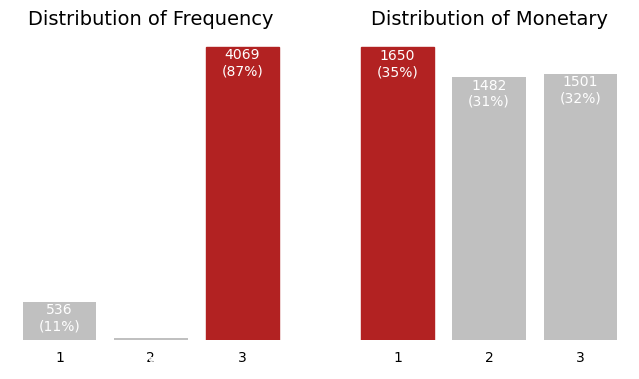

In [267]:
# построим графики распределения рангов для F и M, наиболее важных показателей
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for i, p in enumerate(['F', 'M']):
    parameters = {'F':'Frequency','M':'Monetary', }
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

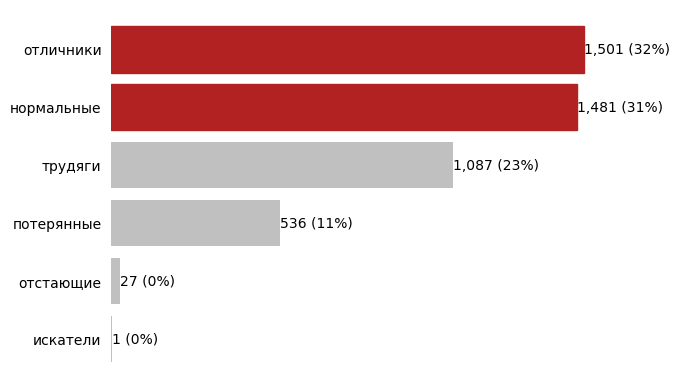

In [269]:
# посмотрим сколько студентов в каждом кластере
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['отличники', 'нормальные']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left')
plt.show()

#### Сегменты с 100% завершаемостью (все попытки сдать экзамен успешные):
`отличники`(средний балл выше 76): все сдали на отлично, вероятно, лояльны и легко справились с экзаменом - вероятно, мотивированы обучаться еще (на уровень выше, например);\
`нормальные`(средний балл 56-76): в целом как отличники, но сдают хуже;\
`трудяги`(средний балл 40-56): поучились, но только на троечку, возможно, мало мотивации учиться у нас - можно выяснить причины.
#### Сегменты с 50% завершаемостью (половина из попыток сдать экзамен успешны):
`искатели`(средний балл 56-76): брали у нас не один курс, но не со всеми справились, тоже активны и, вероятно, готовы еще остаться с нами;\
`отстающие`(средний балл до 56): не со всеми курсами справились, в среднем набирают минимум баллов - им интересны наши курсы, но, например, возникают какие-то трудности (технические, по наполнению и т.п.) или у них почему-то еще нет мотивации получать максимум баллов.
#### Сегменты с 0% завершаемостью (ни один раз не сдали экзамен успешно):
`потерянные`(средний балл до 40): попробовали наши курсы, но не смогли сдать ни один экзамен, не вернувшись за 2 года к другим нашим курсам - возможно, что-то оттолкнуло в нашем продукте или экзамены слишком сложные, это можно выяснить дальше.

# Выводы:

Можно сделать вывод, что около 60% студентов обладают высоким средним баллом за экзамен (возможно, и мотивацией учиться у нас).

23% студентов с небольшим средним количеством баллов может говорить о наличии у них сниженной мотивации учиться у нас - это в целом нормально, но можно и более детально изучить их поведение.

Интерес вызывает 11% студентов, которые так и не смогли окончить наш курс - это относительно немного, однако это также может говорить о том, что их опыт учебы с нами не заинтересовал их успешно завершить или продолжить обучение.

Почти равномерное распределение средней оценки за экзамен (Monetary) говорит об отсутствии признаков жесткого перекоса в сложности экзаменов, большая часть с ними справляется.
При этом почти все (87%, Frequency) студенты успешно справляются со всеми начатыми курсами, успешно сдав экзамен.